In [87]:
library(tidyverse)
library(rhdf5)
library(stringr)
library(ggpmisc)
source("plotting_common.r")

In [88]:
read_problem = function(filepath) {
    dir = gsub("_", "-", gsub("\\..*$", "", basename(dirname(filepath))))
    robust = grepl("robust", filepath)
    read_csv(filepath, col_types = cols()) %>% mutate(bal=dir, robust=robust, filename=filepath)
}
read_problems = function(filepat, solvername) {
    bind_rows(lapply(Sys.glob(file.path("../ba-problems/*.problem", filepat)), read_problem)) %>%
    mutate(solver = solvername)
}
read_bals = function(filepat, solvername) {
    bind_rows(lapply(Sys.glob(file.path("../ba-problems/bal-*", filepat)), read_problem)) %>%
    mutate(solver = solvername)
}

In [140]:
raw =
bind_rows( read_problems("ceres_benchmark_pbjacobi.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_eta01.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_robust.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_pbjacobi_robust01.csv", "Point Block Jacobi")
         , read_problems("ceres_benchmark_visibility.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_eta01.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_robust.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_robust01.csv", "Visibility")
         , read_problems("ceres_benchmark_visibility_tridiagonal.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_visibility_tridiagonal_eta01.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_visibility_tridiagonal_robust.csv", "Visibility Tridiagonal")
         , read_problems("ceres_benchmark_multigrid.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_eta01.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_robust.csv", "Multigrid")
         , read_problems("ceres_benchmark_multigrid_robust01.csv", "Multigrid")
         , read_problems("multigrid_benchmark_smooth.csv", "SA Multigrid")
         )
ceres = raw %>% group_by(bal, solver, eta, robust) %>% arrange(problem) %>% #dplyr::filter(problem > 0) %>%
  mutate(ctime = cumsum(setup_time)+cumsum(solve_time), ctime_setup=cumsum(setup_time), ctime_solve=cumsum(solve_time), costmin=cummin(cost))

In [141]:
# Filter rows so it is as if we solved all problem to the same tolerance
mincost = ceres %>%
  group_by(bal, solver, eta, robust) %>% summarize(mincost=min(cost))
maxmincost = mincost %>% group_by(bal, eta, robust) %>%
             summarize(maxmincost=if(any(grepl("block", bal))) {1e-8} else {max(mincost)})
joined = inner_join(ceres, maxmincost, by=c("bal", "eta", "robust"))
filt = function(d) {
    above_cost = d %>% dplyr::filter(costmin > maxmincost)
    last_prob = if(length(above_cost$problem) == 0) {
        1
    } else {
        max(above_cost$problem) + 1
    }
    d %>% dplyr::filter(problem <= last_prob)
}
sametol_all = joined %>% group_by(bal, solver, eta, robust) %>% group_modify(~filt(.x))
d_sametol = sametol_all %>% dplyr::filter(is.element(solver,
    c("Multigrid", "Visbility Tridiagonal", "Visibility", "Point Block Jacobi")))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


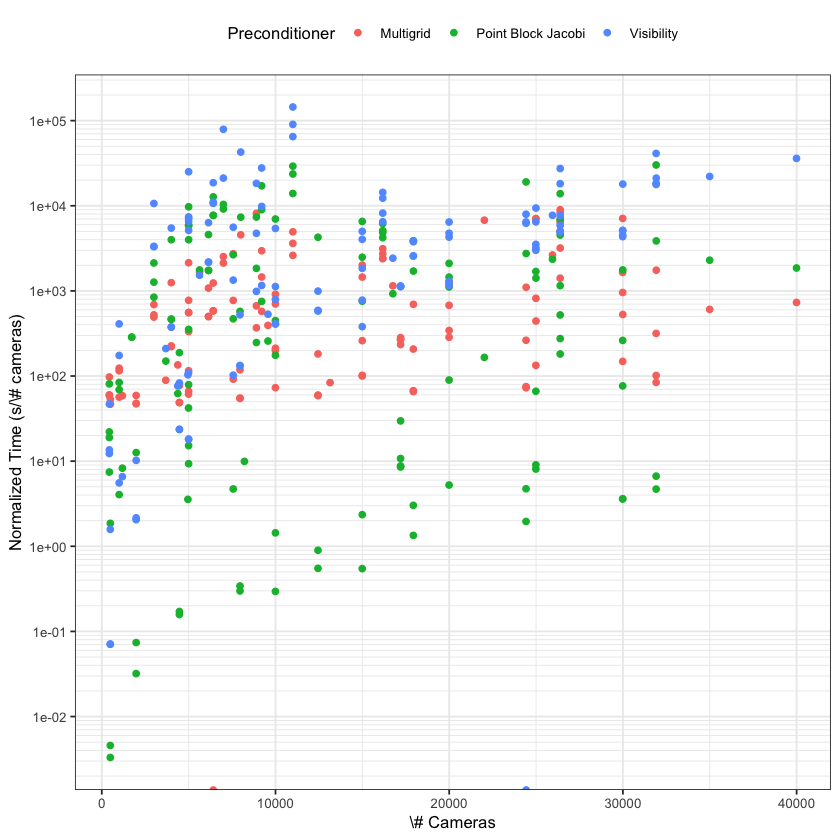

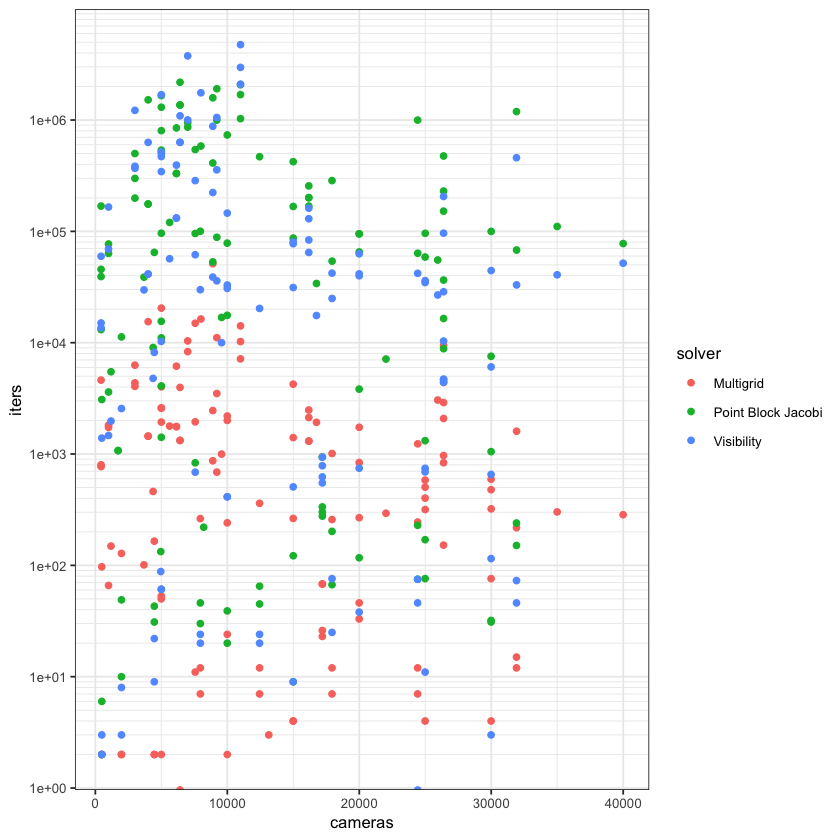

Warning message:
“Removed 7 rows containing missing values (geom_point).”


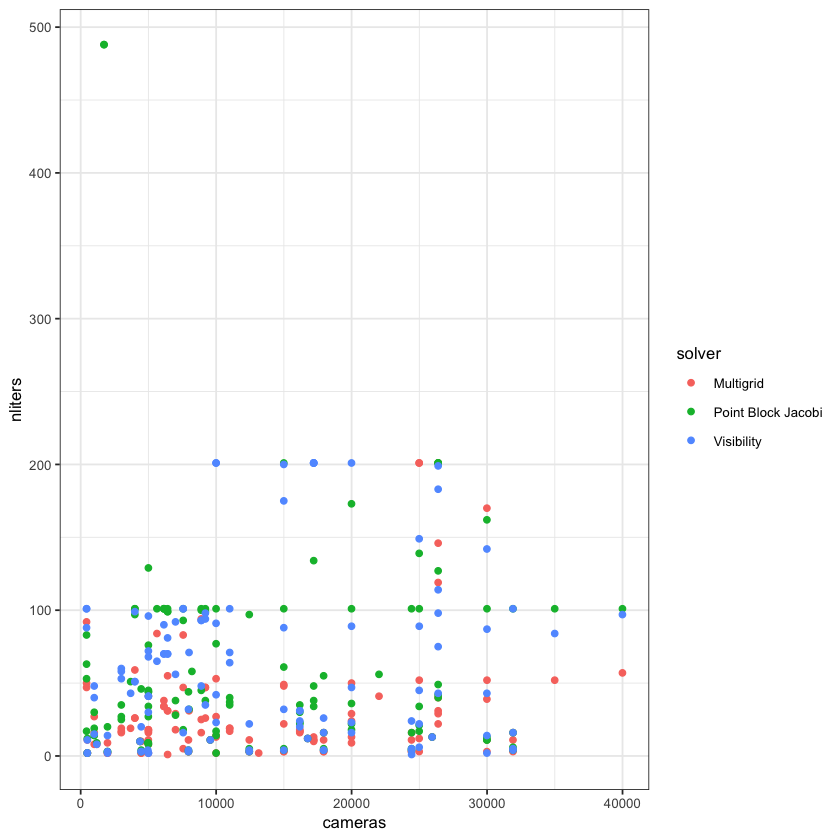

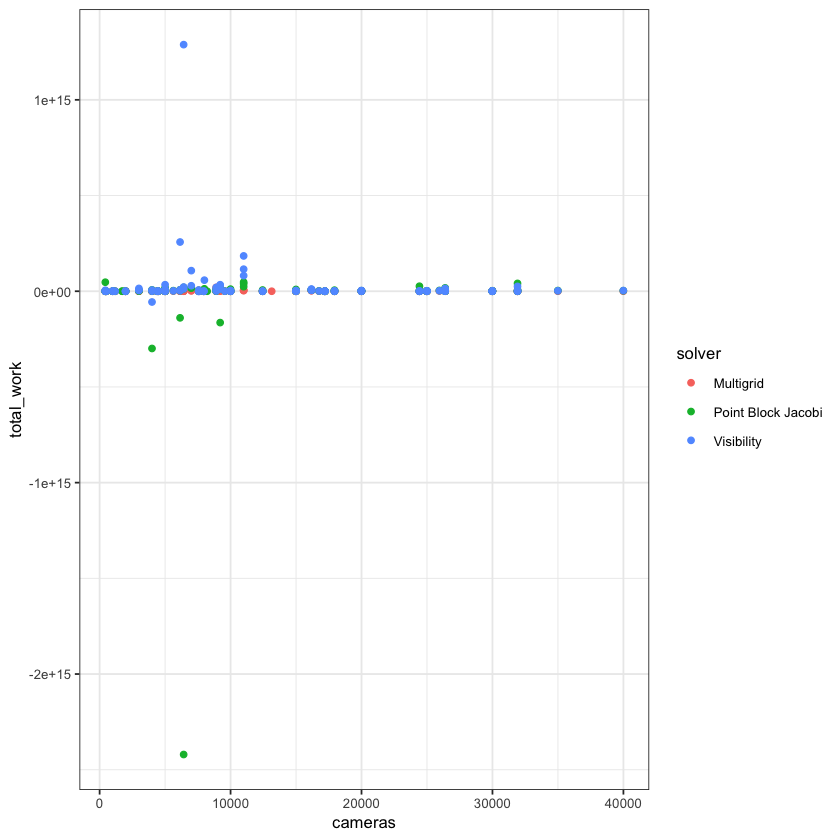

In [142]:
# scaling on all problems
d_agg = d_sametol %>% group_by(solver, bal, eta, robust) %>%
  summarize( cameras=first(cameras), total_work=sum(flops)
           , solve_time=sum(solve_time), setup_time=sum(setup_time)
           , total_time=sum(solve_time)+sum(setup_time), mincost=min(cost)
           , ctime=max(ctime)
           , iters=sum(iters), nliters=n())
ggplot(d_agg, aes(x=cameras, y=solve_time+setup_time, color=solver)) +
    geom_point() +
    scale_y_log_eng() +
    labs(color="Preconditioner") +
    xlab("\\# Cameras") +
    ylab("Normalized Time (s/\\# cameras)") +
    theme(legend.position="top")
ggplot(d_agg, aes(x=cameras, color=solver, y=iters)) + geom_point() + scale_y_log_eng()
ggplot(d_agg, aes(x=cameras, color=solver, y=nliters)) + geom_point()
ggplot(d_agg, aes(x=cameras, color=solver, y=total_work)) + geom_point()

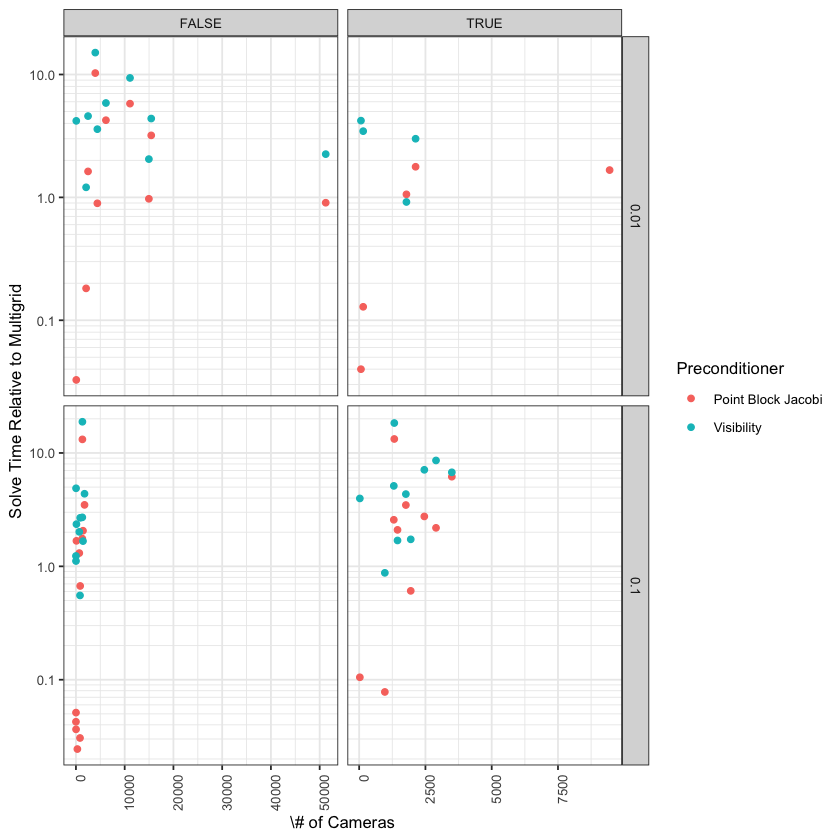

[1] "Writing to ../paper/reltime.tex"


pdf 
  2

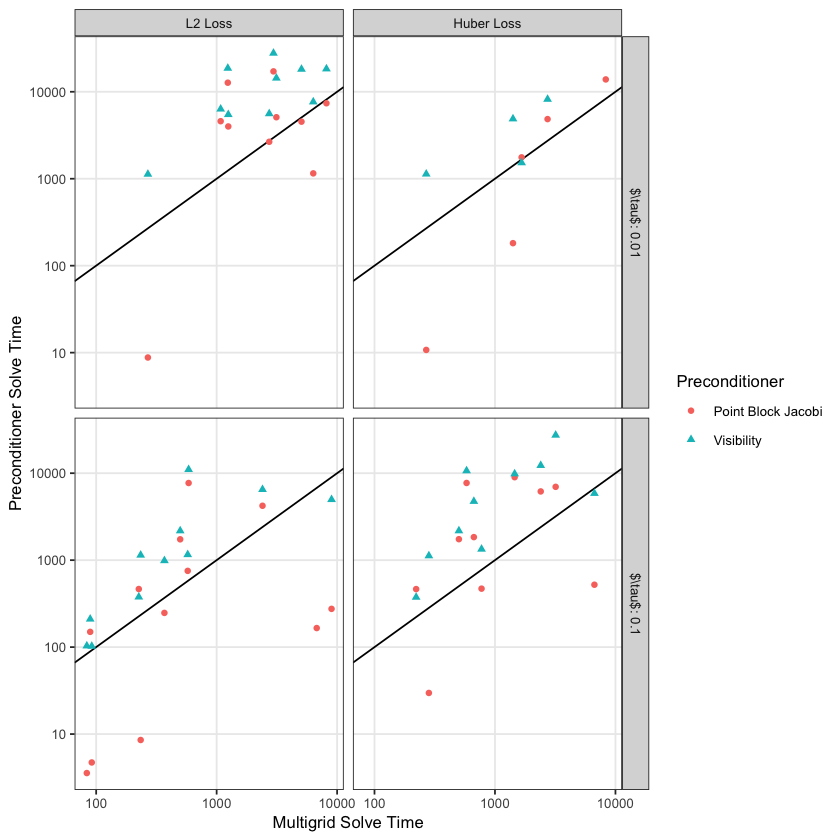

solver,eta,robust,maxspeedup,avgspeedup,medianspeedup
<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
Point Block Jacobi,0.01,FALSE,10.271043,1.1993379,1.3002748
Point Block Jacobi,0.01,TRUE,1.774827,0.4380236,1.0587398
Point Block Jacobi,0.10,FALSE,13.176296,0.3955119,0.9902498
Point Block Jacobi,0.10,TRUE,13.284067,1.4669143,2.3793616
Visibility,0.01,FALSE,15.068514,4.1157852,4.2880297
Visibility,0.01,TRUE,4.212424,2.5167928,3.2300163
Visibility,0.10,FALSE,18.843535,2.4314501,2.3553916
Visibility,0.10,TRUE,18.364831,4.2009255,4.7305421


solver,maxspeedup,avgspeedup,medianspeedup
<chr>,<dbl>,<dbl>,<dbl>
Point Block Jacobi,13.28407,0.7712809,1.626813
Visibility,18.84354,3.3169551,3.589717


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


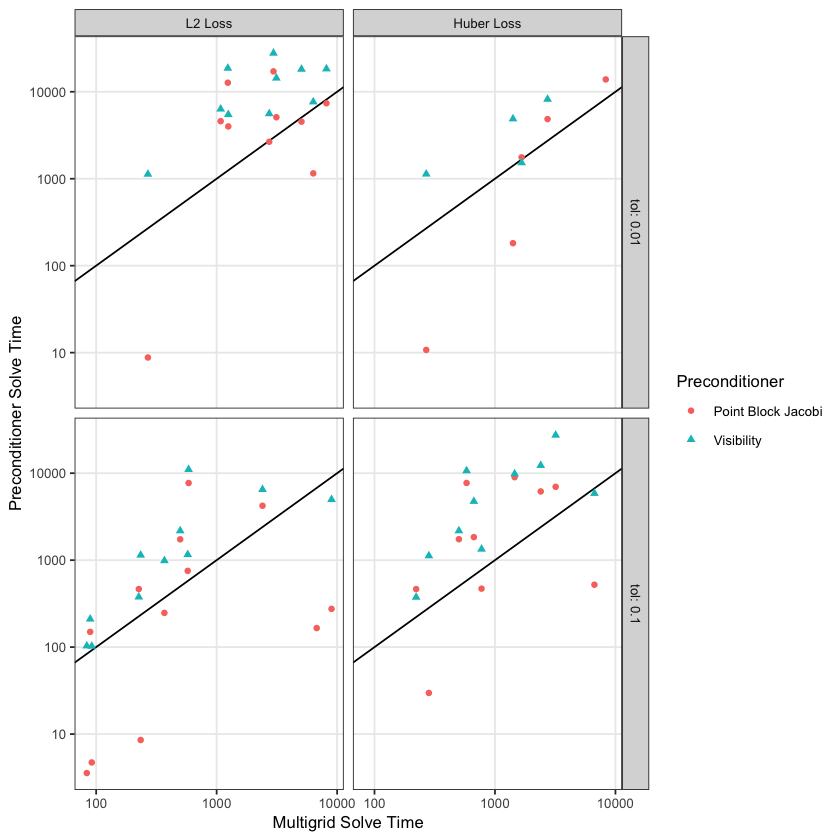

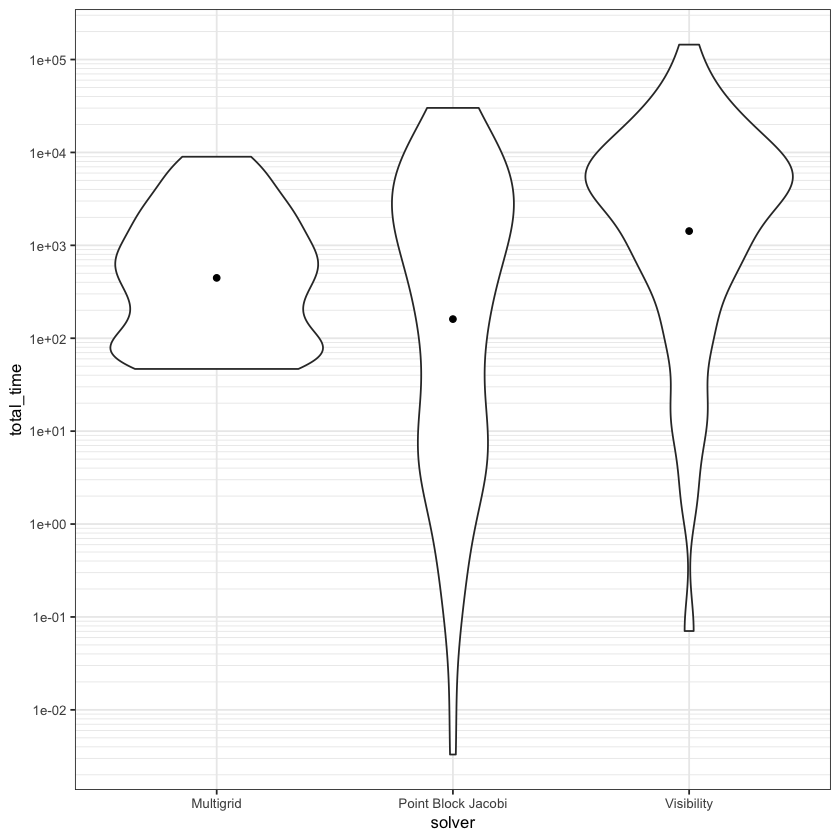

In [92]:
# relative performance
# x = d_agg %>% group_by(solver) %>% group_map(~ unique(.x$bal))
# probs = x[[1]]
# for (i in 2:length(x)) {
#   probs = intersect(probs, x[[i]]);
# }
probs = intersect(unique(subset(d_agg, solver == "Multigrid")$bal),
                  unique(subset(d_agg, solver == "Point Block Jacobi")$bal))
d_rel = d_agg %>% dplyr::filter(#eta == 0.1 & 
                                #robust == FALSE &
                                #cameras < 15000 &
                                cameras > 2500 &
                                is.element(bal, probs) &
                                !grepl("path", bal) &
                                !grepl("block", bal) &
                                !grepl("line", bal)) %>%
  group_by(bal, eta, robust) %>%
  dplyr::filter(length(total_time[solver == "Multigrid"]) > 0) %>%
  mutate(mgtime=total_time[solver == "Multigrid"],
         reltime=total_time/total_time[solver == "Multigrid"],
         difficulty=iters[solver == "Multigrid"]) %>%
  ungroup() %>% dplyr::filter(solver != "Multigrid")
ggplot(d_rel, aes(x=difficulty, y=reltime, color=solver)) + geom_point() +
  scale_y_log_eng() + ylab("Solve Time Relative to Multigrid") +
  xlab("\\# of Cameras") + labs(color = "Preconditioner") +
  theme(legend.position="right") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  facet_grid(rows=vars(eta), cols=vars(robust), scales="free",
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x)))
        
d_rel %>% {
ggplot(d_rel, aes(x=mgtime, y=total_time, shape=solver, color=solver, label=bal)) +
  geom_abline(intercept=0,slope=1)+
  geom_point() +
  # geom_text_repel(data=dplyr::filter(.,total_time<mgtime)) +
  scale_x_log_eng() + scale_y_log_eng() +
  xlab("Multigrid Solve Time") + ylab("Preconditioner Solve Time") +
  labs(color = "Preconditioner", shape = "Preconditioner") +
  facet_grid(rows=vars(eta), cols=vars(robust),# scales="free",
             labeller=labeller(.cols=as_labeller(c("TRUE"="Huber Loss","FALSE"="L2 Loss")),
                               .rows=as_labeller(function(x)paste("$\\tau$:",x)))) +
  #guides(shape=guide_legend(nrow=2,byrow=TRUE)) +
  theme(panel.grid.minor = element_blank()) +
  theme(legend.position="right")
}
tikz_file("../paper/reltime.tex")
d_rel %>% {
ggplot(d_rel, aes(x=mgtime, y=total_time, shape=solver, color=solver, label=bal)) +
  geom_abline(intercept=0,slope=1)+
  geom_point() +
  # geom_text_repel(data=dplyr::filter(.,total_time<mgtime)) +
  scale_x_log_eng() + scale_y_log_eng() +
  xlab("Multigrid Solve Time") + ylab("Preconditioner Solve Time") +
  labs(color = "Preconditioner", shape = "Preconditioner") +
  facet_grid(rows=vars(eta), cols=vars(robust),# scales="free",
             labeller=labeller(.cols=as_labeller(c("TRUE"="Huber Loss","FALSE"="L2 Loss")),
                               .rows=as_labeller(function(x)paste("tol:",x)))) +
  #guides(shape=guide_legend(nrow=2,byrow=TRUE)) +
  theme(panel.grid.minor = element_blank()) +
  theme(legend.position="right")
}
ggsave("../../thesis/reltime.pdf",width=6,height=5)

# from https://stackoverflow.com/questions/2602583/geometric-mean-is-there-a-built-in
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
d_rel %>% group_by(solver, eta, robust) %>%
  summarize(maxspeedup=max(reltime),avgspeedup=gm_mean(reltime),medianspeedup=median(reltime))
d_rel %>% group_by(solver)%>%
  summarize(maxspeedup=max(reltime),avgspeedup=gm_mean(reltime),medianspeedup=median(reltime))
ggplot(d_agg %>% dplyr::filter(is.element(bal, probs)), aes(x=solver,y=total_time)) +
  geom_violin() +
  scale_y_log_eng() +
  stat_summary(fun.y=mean, geom="point")

[1] "Writing to ../paper/nonlinear_cost_vs_iteration.tex"


pdf 
  2

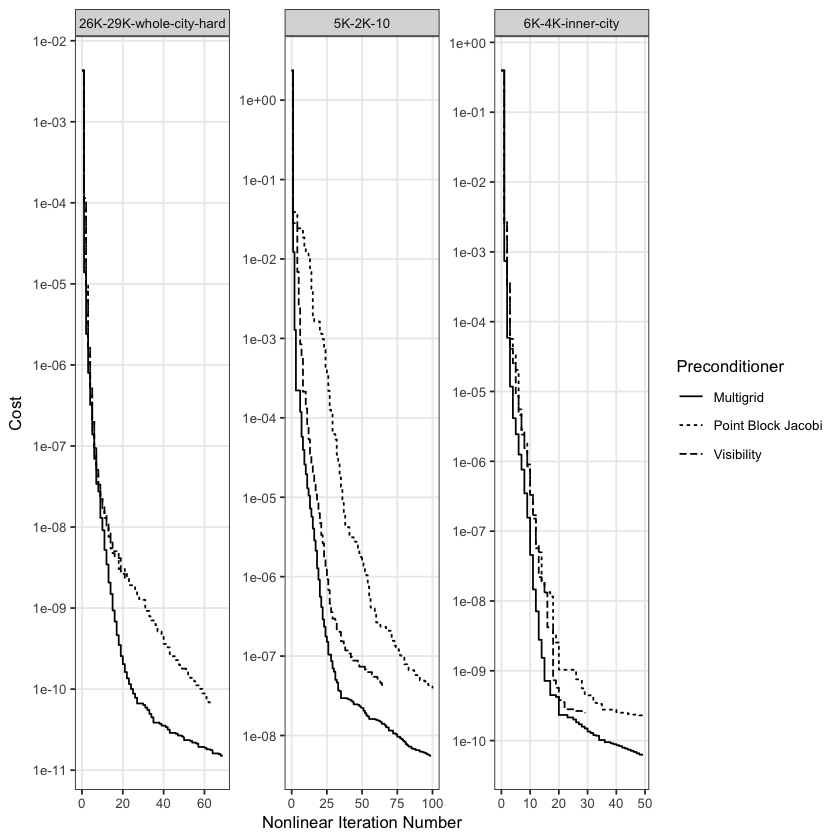

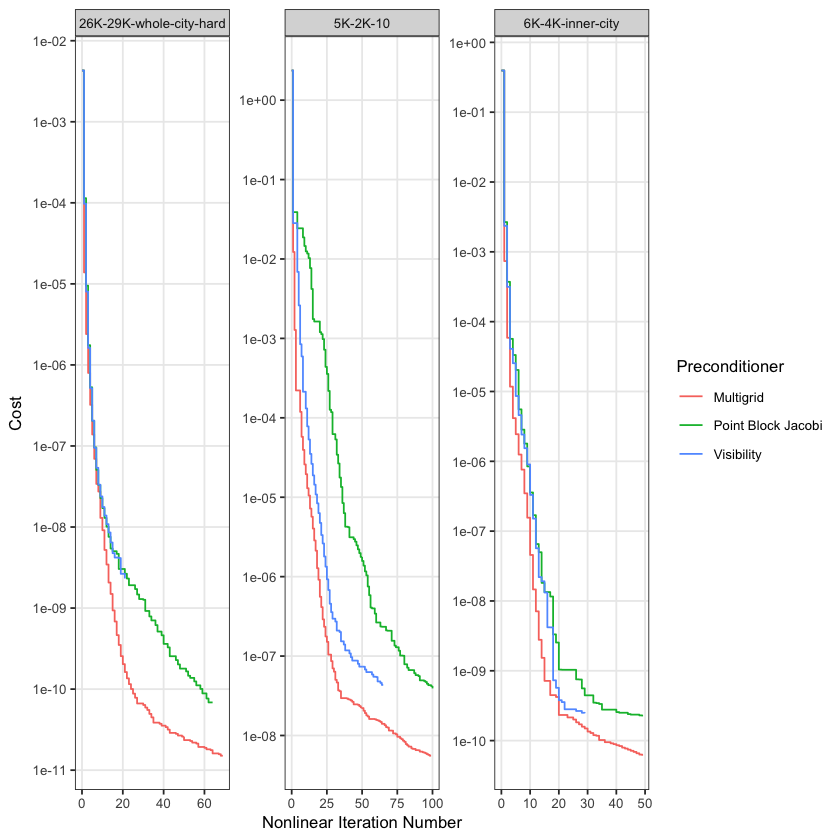

[1] "Writing to ../paper/nonlinear_cost_vs_time.tex"


pdf 
  2

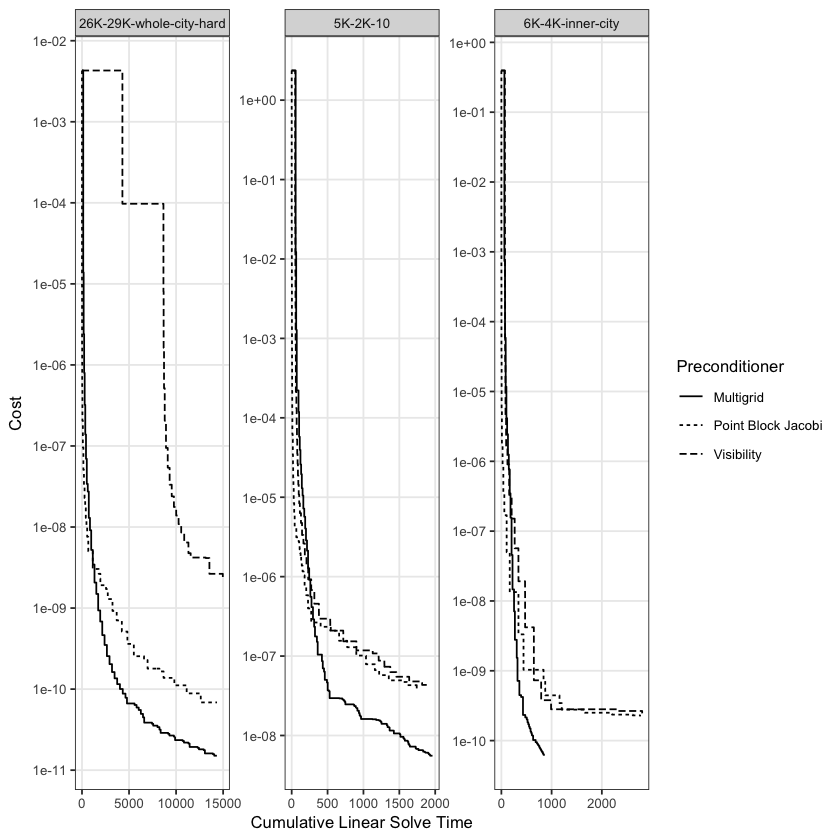

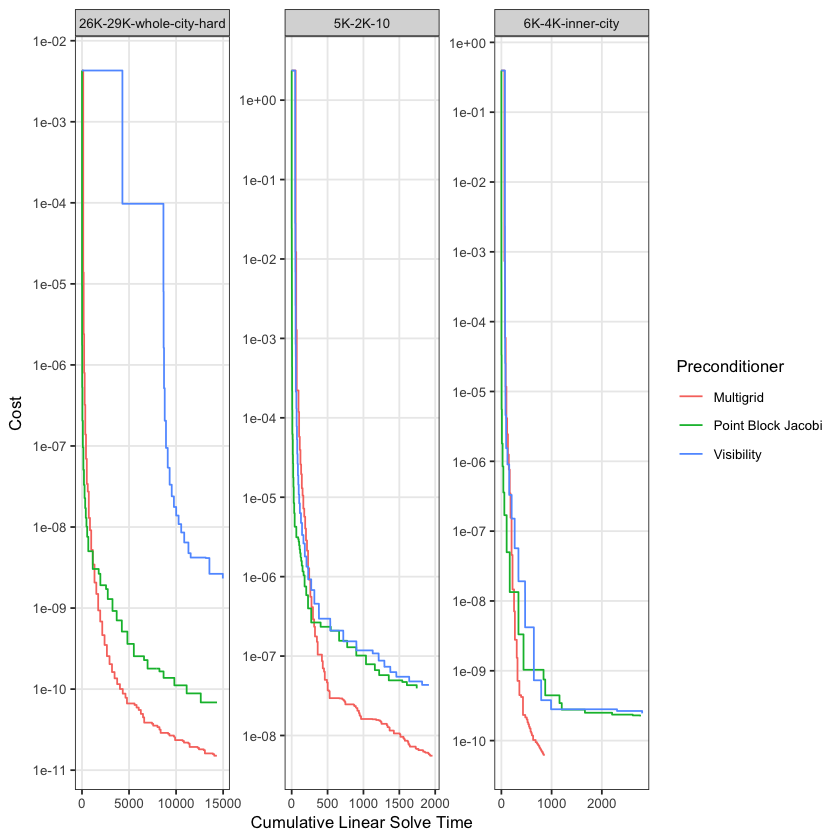

In [93]:
probs = tibble(name=c("6K-4K-inner-city", "5K-2K-10", "26K-29K-whole-city-hard"), lim=c(3000, 2000, 15000))
d_combined = ceres %>%
  dplyr::filter(#is.element(bal, probs$name) &
                !grepl("path", bal) &
                cameras > 3000 &
                solver != "SA Multigrid" & 
                eta == 0.1 &
                robust == TRUE
               )
filt = function(bal) {
    probs[probs$name == bal[1],]$lim[1]
}
d_combined = d_combined %>% group_by(bal) %>% dplyr::filter(ctime <= filt(bal))
d_combined = d_combined %>% dplyr::filter(bal != "6K-4K-inner-city" | problem < 50)

ggplot(d_combined, aes(x=problem, y=costmin, linetype=solver)) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_step() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Nonlinear Iteration Number") +
  #geom_hline(aes(yintercept=maxmincost), color="red") +
  labs(linetype="Preconditioner", size="Linear Solve Time") +
  theme(legend.position="right")
tikz_file("../paper/nonlinear_cost_vs_iteration.tex", width=6)
ggplot(d_combined, aes(x=problem, y=costmin, color=solver)) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_step() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Nonlinear Iteration Number") +
  labs(color="Preconditioner", size="Linear Solve Time") +
ggsave("../../thesis/nonlinear_cost_vs_iteration.pdf", width=6, height=5)
                                  
ggplot(d_combined, aes(x=ctime, y=costmin, linetype=solver,
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_step() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Cumulative Linear Solve Time") +
  # geom_hline(aes(yintercept=maxmincost), linetype=3) +
  labs(linetype="Preconditioner", size="Linear Solve Time") +
  theme(legend.position="right")
tikz_file("../paper/nonlinear_cost_vs_time.tex", width=6)
                                  
ggplot(d_combined, aes(x=ctime, y=costmin, color=solver,
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3,
             labeller=as_labeller(function(x)gsub("_", "\\\\char`_", x))) +
  geom_step() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() + ylab("Cost") + xlab("Cumulative Linear Solve Time") +
  # geom_hline(aes(yintercept=maxmincost), linetype=3) +
  labs(color="Preconditioner", size="Linear Solve Time") +
  theme(legend.position="right")
ggsave("../../thesis/nonlinear_cost_vs_time.pdf", width=6, height=5)

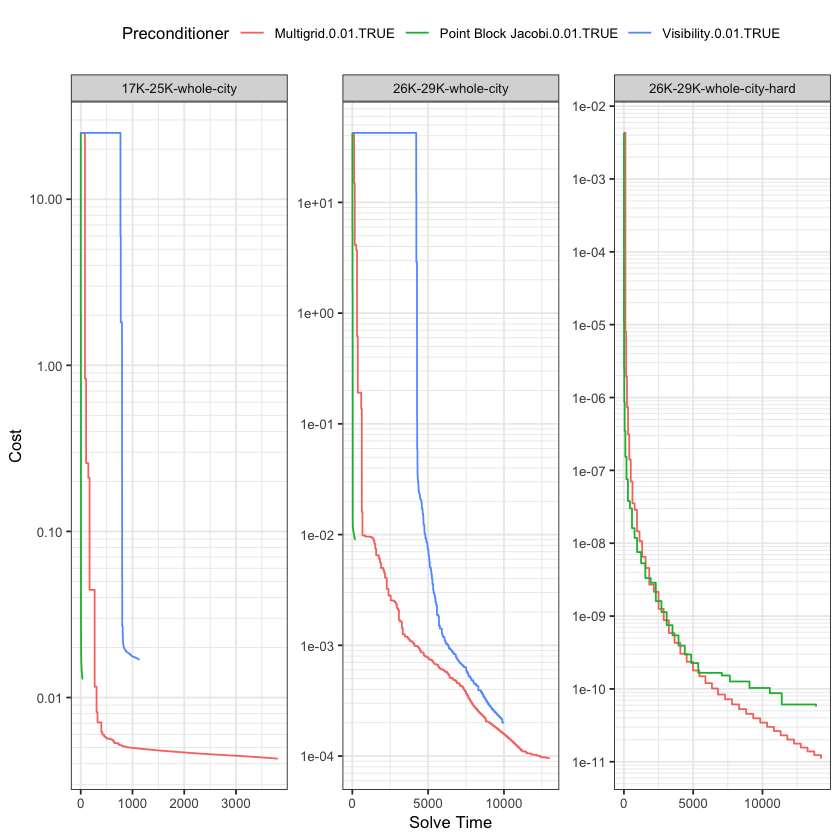

In [94]:
d = ceres %>%
  dplyr::filter(grepl("whole-city", bal) & solver != "SA Multigrid" & eta == 0.01 & robust == TRUE) %>%
  group_by(bal, solver, eta, robust) %>% mutate(ctime=cumsum(solve_time)+cumsum(setup_time))
ggplot(d, aes(x=ctime, y=costmin, color=interaction(solver, eta, robust),
                       #size=setup_time+solve_time
                      )) +
  facet_wrap(vars(bal), scales="free", ncol = 3) +
  geom_step() +
  scale_y_log_eng() +
  #scale_x_log_eng() +
  ylab("Cost") + xlab("Solve Time") +
  #geom_hline(aes(yintercept=maxmincost), linetype=3) +
  labs(color="Preconditioner") +
  theme(legend.position="top")

Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "Writing to ../paper/iteration_counts.tex"


Warning message:
“Transformation introduced infinite values in continuous y-axis”


pdf 
  2

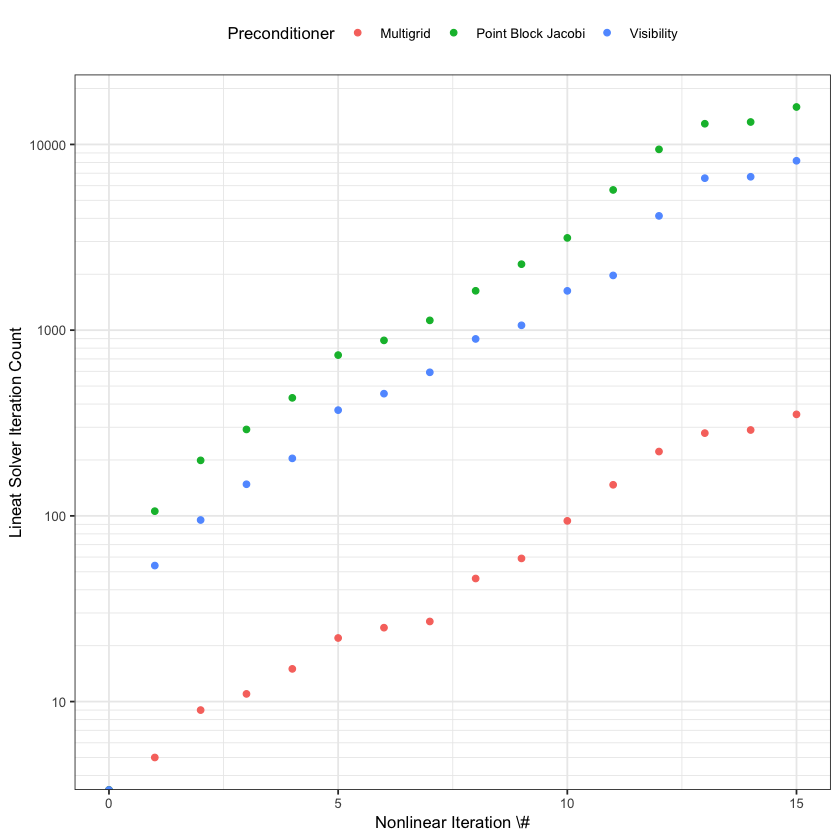

In [95]:
d = d_sametol %>% dplyr::filter(bal == "40-block-drift" & eta == 0.01 & robust == TRUE)
ggplot(d, aes(x=problem, y=iters, color=solver)) +
  geom_point() +
  scale_y_log_eng() +
  labs(color="Preconditioner", x="Nonlinear Iteration \\#", y="Lineat Solver Iteration Count") +
  theme(legend.position="top")
tikz_file("../paper/iteration_counts.tex")

[1] "Writing to ../../thesis/scaling_test.tex"


pdf 
  2

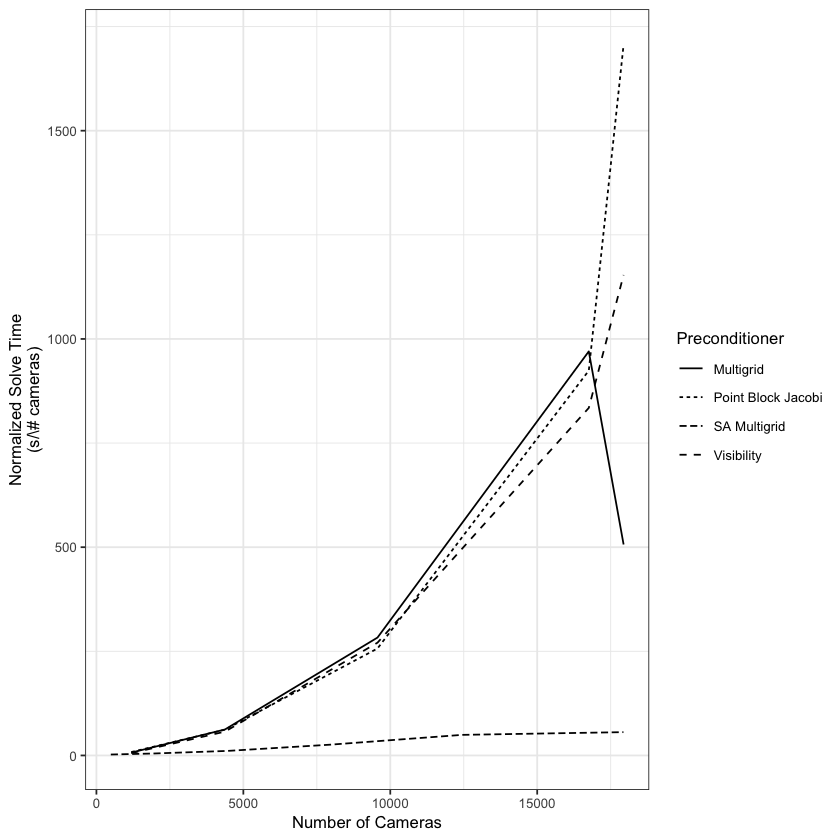

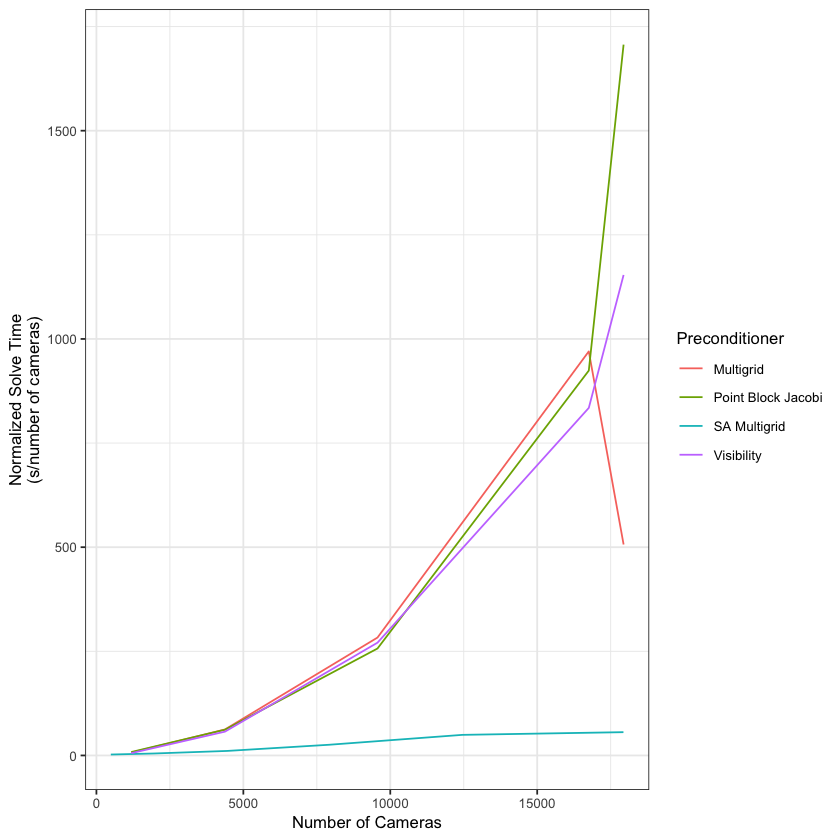

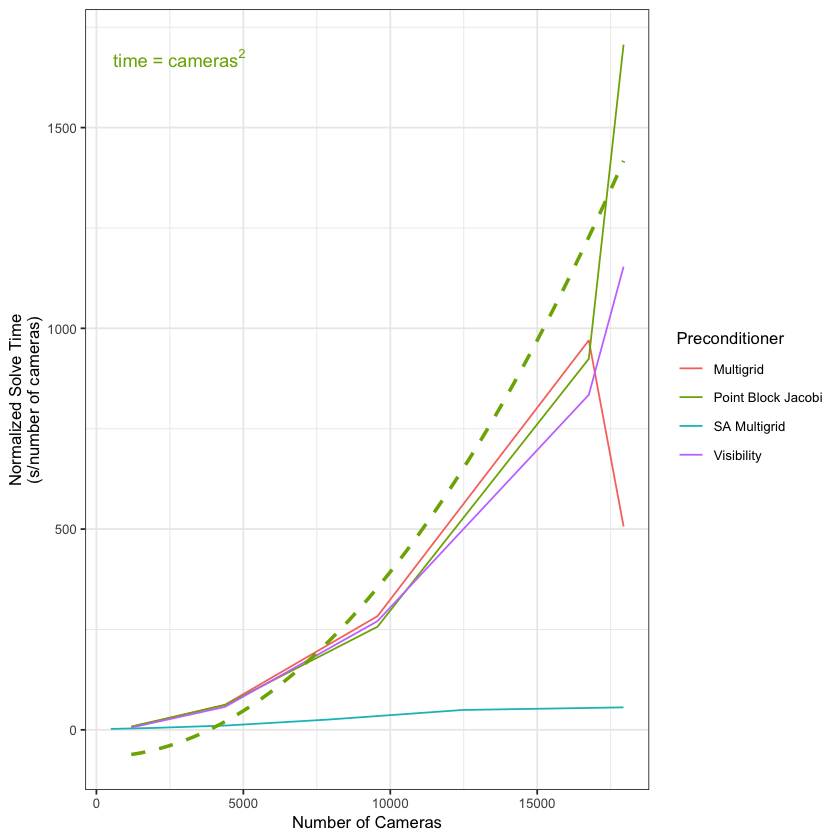

[1] "Writing to ../../thesis/scaling_test_setup.tex"


pdf 
  2

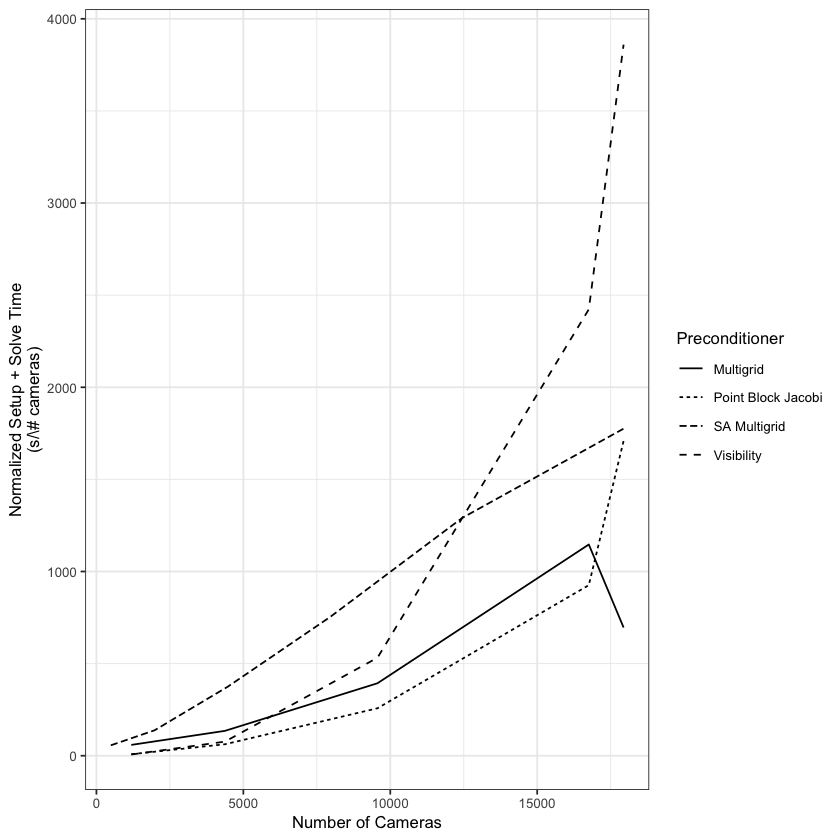

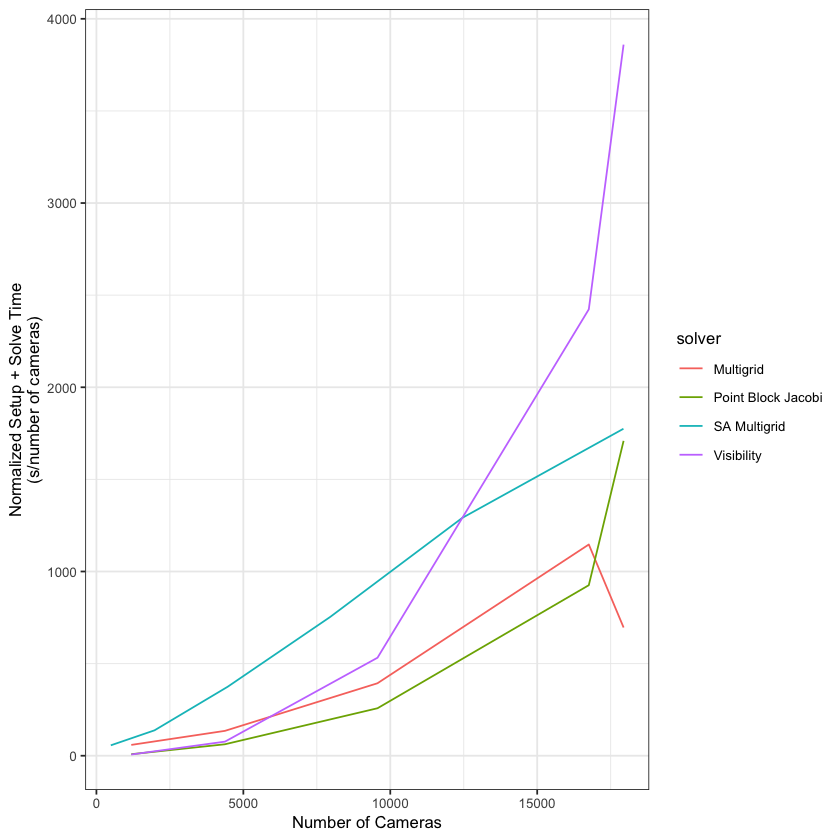

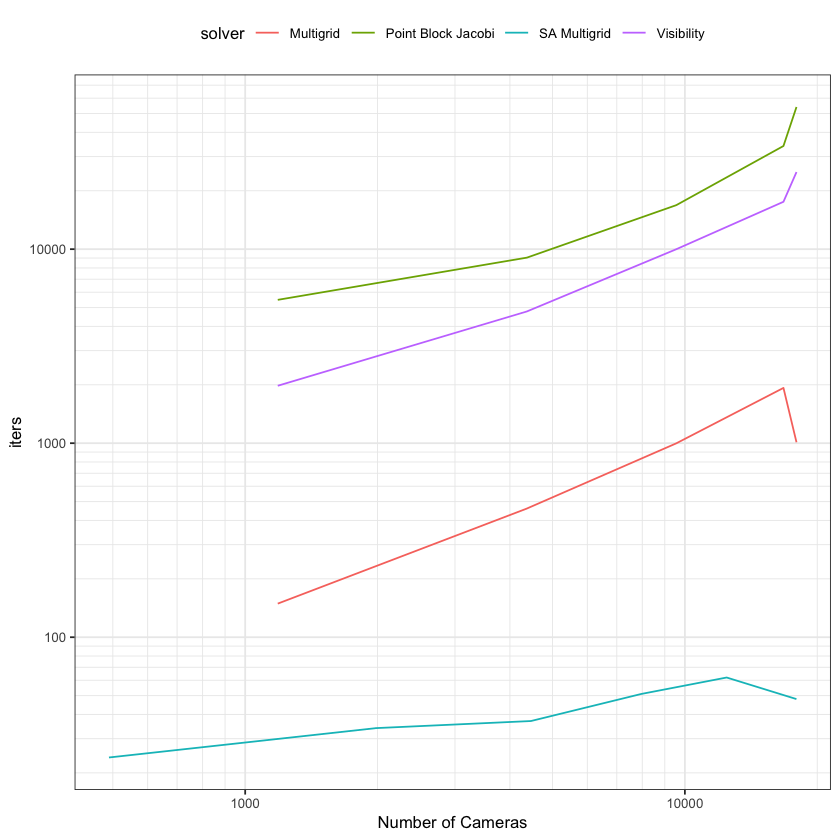

In [134]:
d_block = sametol_all %>% dplyr::filter(grepl("block-drift", bal) & eta == 0.01 & loss == "huber" & cameras < 20000)
path_sametol = d_block %>% group_by(bal, solver) %>%
    summarize(total_time=sum(setup_time)+sum(solve_time), solve_time=sum(solve_time),
              setup_time=sum(setup_time), iters=sum(iters), cameras=first(cameras))
# summary(lm(total_time ~ cameras, d_path[d_path$solver == "multigrid",]))
# summary(lm(log(total_time) ~ cameras, d_path[d_path$solver == "pbjacobi-implicit",]))
# summary(lm(log(total_time) ~ cameras, d_path[d_path$solver == "visibility",]))

# TODO: should use nnz here
ggplot(path_sametol, aes(x=cameras, y=solve_time, linetype=solver)) +
  geom_line() +
  #geom_smooth(formula = y ~ I(x^(4/2)), method=lm, se=FALSE, data = path_sametol %>% dplyr::filter(solver == "Point Block Jacobi")) +
  ylab("Normalized Solve Time\n(s/\\# cameras)") +
  xlab("Number of Cameras") +
  labs(linetype="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="right")
tikz_file("../../thesis/scaling_test.tex", width=6)
ggplot(path_sametol, aes(x=cameras, y=solve_time, color=solver)) +
  geom_line() +
  #geom_smooth(formula = y ~ I(x^(4/2)), method=lm, se=FALSE, data = path_sametol %>% dplyr::filter(solver == "Point Block Jacobi")) +
  ylab("Normalized Solve Time\n(s/number of cameras)") +
  xlab("Number of Cameras") +
  labs(color="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="right")
ggsave("../../thesis/scaling_test.pdf", width=6, height=5)
ggplot(path_sametol, aes(x=cameras, y=solve_time, color=solver)) +
  geom_line() +
  stat_poly_eq(formula = y ~ I(x^(4/2)), aes(label = "time~`=`~cameras^2"), show.legend=FALSE, parse=TRUE, data = path_sametol %>% dplyr::filter(solver == "Point Block Jacobi")) +
  geom_smooth(formula = y ~ I(x^(4/2)), show.legend=FALSE, method=lm, se=FALSE,linetype=2, data = path_sametol %>% dplyr::filter(solver == "Point Block Jacobi")) +
  ylab("Normalized Solve Time\n(s/number of cameras)") +
  xlab("Number of Cameras") +
  labs(color="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="right")
ggsave("../../thesis/scaling_test_fit.pdf", width=6, height=5)
ggplot(path_sametol, aes(x=cameras, y=total_time, linetype=solver)) +
  geom_line() +
  #geom_smooth(formula = y ~ I(x^(3)), method=lm, se=FALSE, data = path_sametol %>% dplyr::filter(solver == "Visibility")) +
  ylab("Normalized Setup + Solve Time\n(s/\\# cameras)") +
  xlab("Number of Cameras") +
  labs(linetype="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="right")
tikz_file("../../thesis/scaling_test_setup.tex", width=6)
ggplot(path_sametol, aes(x=cameras, y=total_time, color=solver)) +
  geom_line() +
  #geom_smooth(formula = y ~ I(x^(3)), method=lm, se=FALSE, data = path_sametol %>% dplyr::filter(solver == "Visibility")) +
  ylab("Normalized Setup + Solve Time\n(s/number of cameras)") +
  xlab("Number of Cameras") +
  labs(linetype="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="right")
ggsave("../../thesis/scaling_test_setup.pdf", width=6, height=5)
ggplot(path_sametol, aes(x=cameras, y=iters, color=solver)) +
  geom_line() +
  #geom_smooth(formula = y ~ I(x^(4/2)), method=lm, se=FALSE, data = path_sametol %>% dplyr::filter(solver == "Point Block Jacobi")) +
  scale_y_log_eng() +
  scale_x_log_eng() +
  xlab("Number of Cameras") +
  labs(linetype="Preconditioner") +
  #guides(linetype=guide_legend(nrow=2,byrow=TRUE)) +
  theme(legend.position="top")

Warning message:
“Transformation introduced infinite values in continuous y-axis”


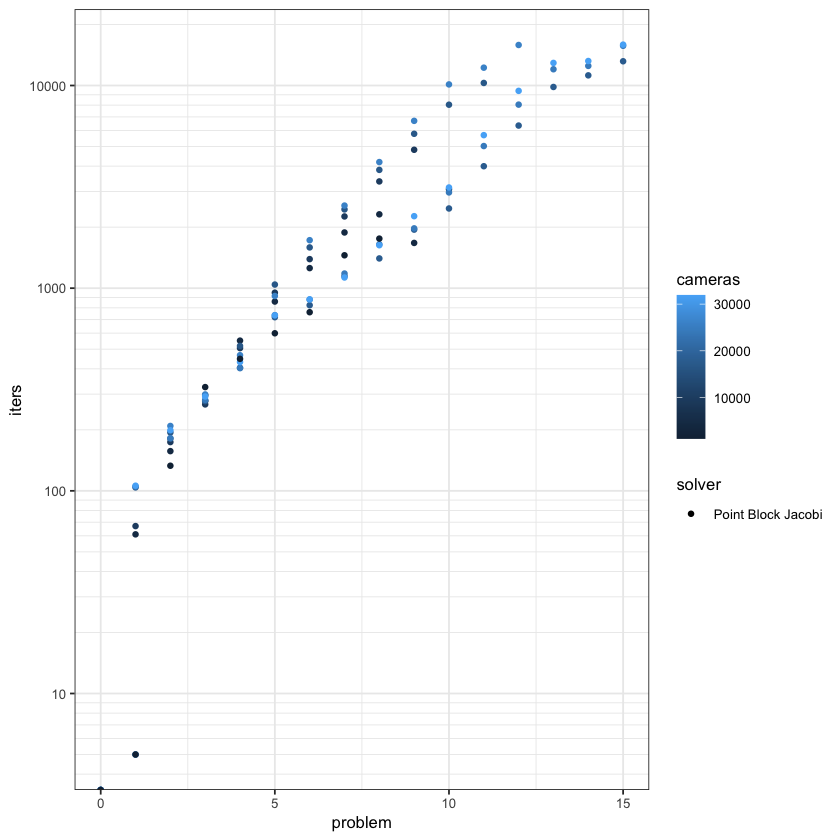

In [97]:
ggplot(d_block %>% dplyr::filter(solver=="Point Block Jacobi"), aes(x=problem, y=iters, shape=solver, color=cameras)) + geom_point() + scale_y_log_eng()

In [98]:
df = d_block %>% group_by(solver, eta, bal) %>% mutate(change=costmin/lag(costmin)) %>%
  summarize(change=last(change), iters=last(iters), cameras=last(cameras)) %>% mutate(m=iters/-log(change))
df %>% group_by(solver) %>% do(slope_m=coef(lm(log(m)~log(cameras), data=.))[2] %>% as_tibble,
                               slope_i=coef(lm(log(iters)~log(cameras), data=.))[2] %>% as_tibble)
ggplot(df, aes(y=iters, x=cameras, linetype=solver)) +
  geom_line() +
  scale_y_log_eng() +
  scale_x_log_eng() +
  theme(panel.grid.minor = element_blank()) +
  labs(linetype="Preconditioner") +
  ylab("Iteration Count") +
  xlab("Number of Cameras")
tikz_file("../../thesis/iters_vs_cameras.tex")
ggplot(df, aes(y=iters, x=cameras, color=solver)) +
  geom_line() +
  scale_y_log_eng() +
  scale_x_log_eng() +
  theme(panel.grid.minor = element_blank()) +
  labs(color="Preconditioner") +
  ylab("Iteration Count") +
  xlab("Number of Cameras")
ggsave("../../thesis/iters_vs_cameras.pdf", width=6, height=5)

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'


Warning message:
“Transformation introduced infinite values in continuous y-axis”


[1] "Writing to ../../thesis/cost_falloff.tex"


Warning message:
“Transformation introduced infinite values in continuous y-axis”


pdf 
  2

[1] "Writing to ../paper/cost_falloff.tex"


Warning message:
“Transformation introduced infinite values in continuous y-axis”


pdf 
  2

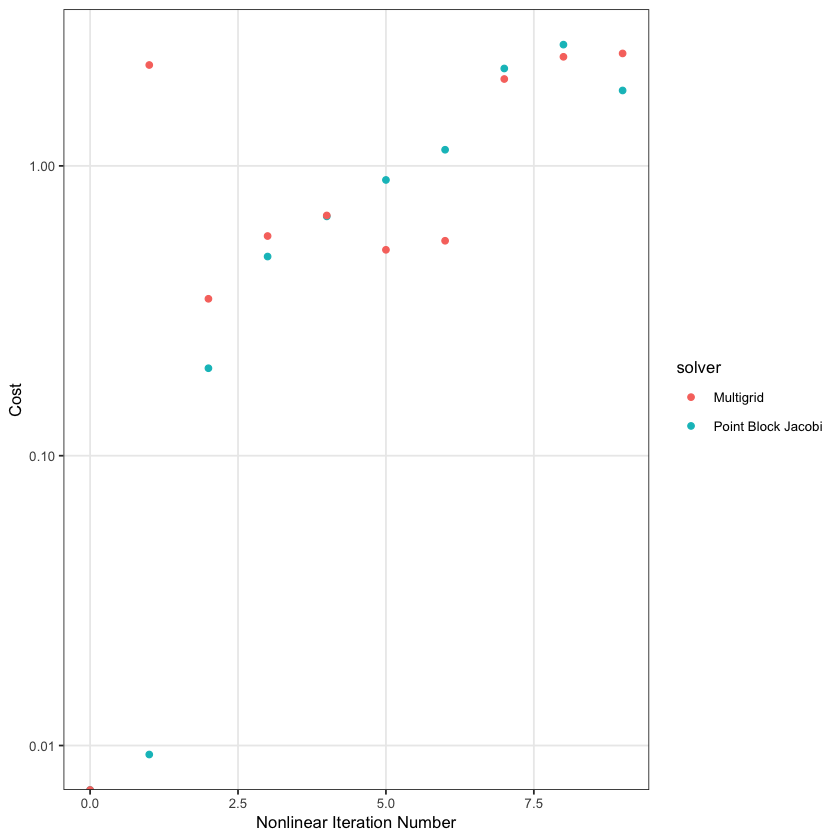

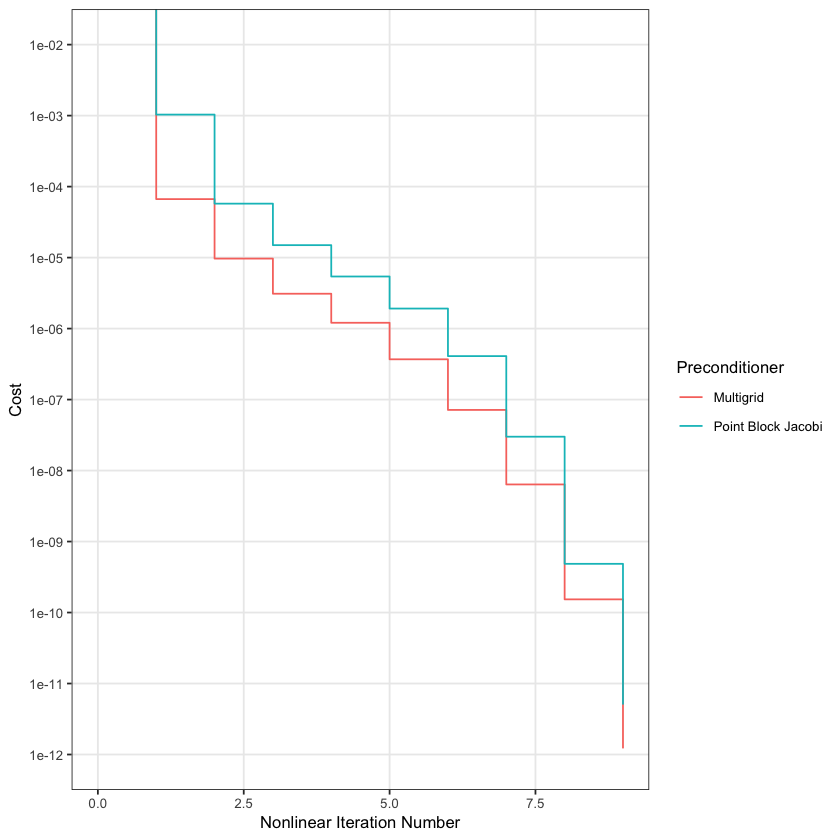

In [153]:
d = ceres %>% dplyr::filter(bal == "5-block-drift" & eta == 0.01 & robust == TRUE & solver != "Visibility")
ggplot(d, aes(x=problem, y=solve_time, color=solver)) +
  geom_point() +
  scale_y_log_eng() +
  theme(panel.grid.minor = element_blank()) +
  # coord_cartesian(ylim=c(1e-12, 1e-2), expand=TRUE) +
  ylab("Cost") +
  xlab("Nonlinear Iteration Number") +
  labs(linetype="Preconditioner") +
  theme(legend.position="right")
tikz_file("../../thesis/cost_falloff.tex")
tikz_file("../paper/cost_falloff.tex")
ggplot(d, aes(x=problem, y=costmin, color=solver)) +
  geom_step() +
  scale_y_log_eng() +
  theme(panel.grid.minor = element_blank()) +
  coord_cartesian(ylim=c(1e-12, 1e-2), expand=TRUE) +
  ylab("Cost") +
  xlab("Nonlinear Iteration Number") +
  labs(color="Preconditioner")
ggsave("../../thesis/cost_falloff.pdf",width=6,height=5)

[1] "Writing to ../../thesis/cond_diameter.tex"


pdf 
  2

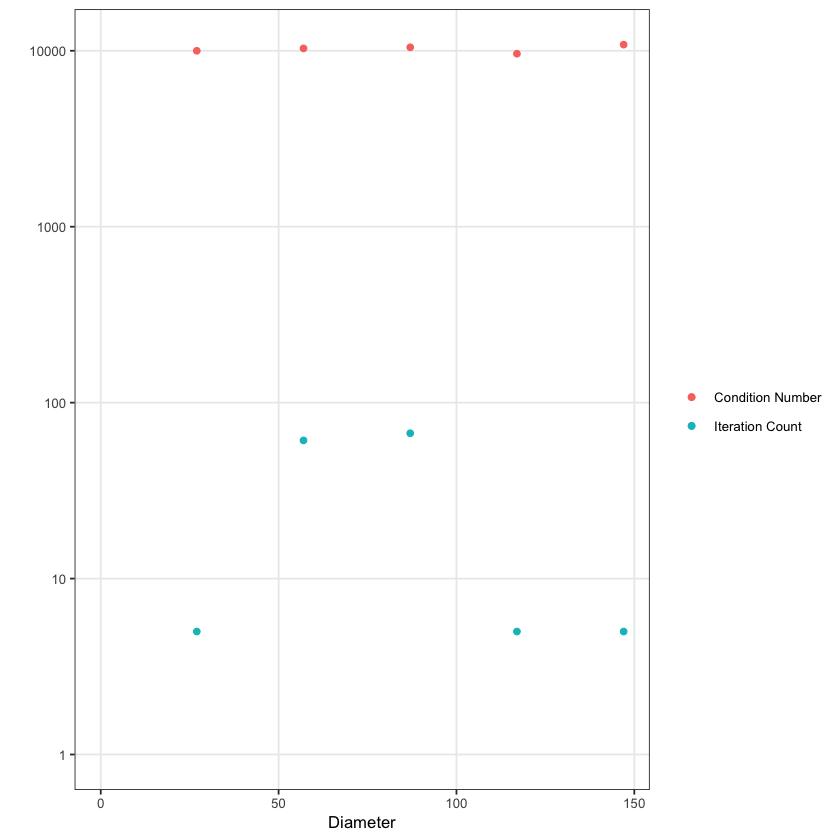

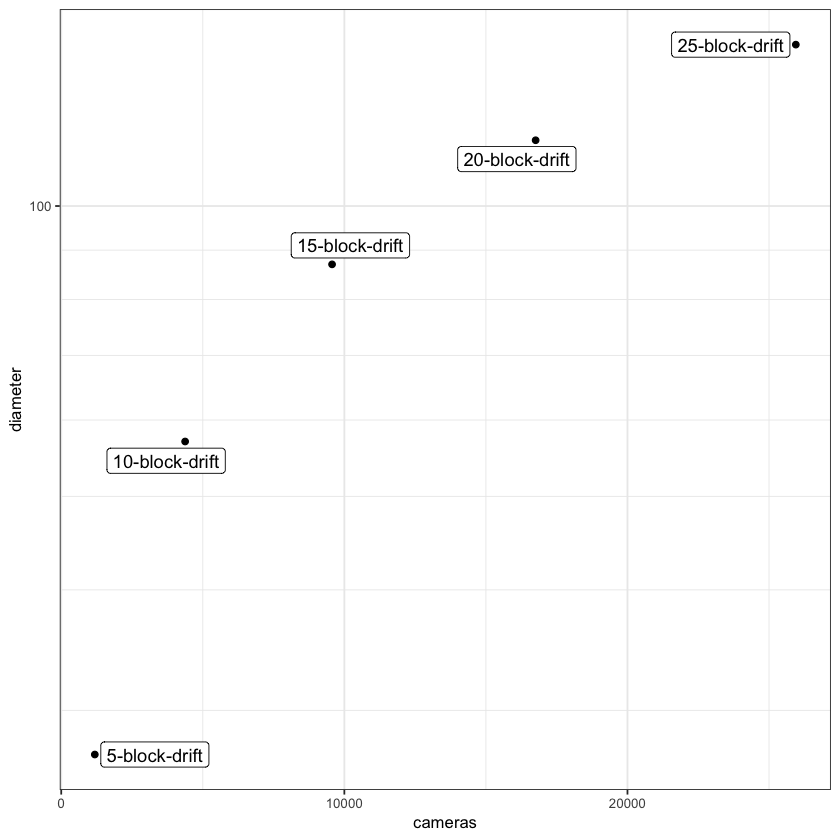

In [100]:
d = ceres %>% ungroup() %>% dplyr::filter(problem==1 & solver=="Point Block Jacobi" & eta==0.01 & robust==TRUE) %>% select(bal, cameras, iters)
conds = inner_join(bind_rows(lapply(Sys.glob("../ba-problems/*.problem/condition_number_1.csv"),
                                   function(f) {
                                       egs = h5read(gsub(".csv","_smallest.h5", gsub("condition_number","eig",f)), "eigenvalues")
                                       egl = h5read(gsub(".csv","_largest.h5", gsub("condition_number","eig",f)), "eigenvalues")
                                       read_problem(f) %>% mutate(ev1=egs[1],ev2=egs[2],cond2=egl[1]/egs[1])
                                               })),
                  d, by="bal")
dias = inner_join(bind_rows(lapply(Sys.glob("../ba-problems/*.problem/diameter.csv"), read_problem)), conds, by="bal")
dias = dias %>% dplyr::filter(grepl("block-drift", bal))
ggplot(dias, aes(x=diameter,y=cond2,label=bal)) +
  #geom_point() +
  geom_point(aes(color="Condition Number")) +
  geom_point(aes(y=iters, color="Iteration Count")) +
  scale_y_log_eng(limits=c(1,NA)) +
  xlim(c(0,NA)) +
  theme(panel.grid.minor = element_blank()) +
  #geom_label_repel() +
  labs(color="") +
  ylab("") +
  xlab("Diameter")
tikz_file("../../thesis/cond_diameter.tex")
ggplot(dias, aes(x=cameras,y=diameter,label=bal)) + geom_point() + scale_y_log_eng() + geom_label_repel()

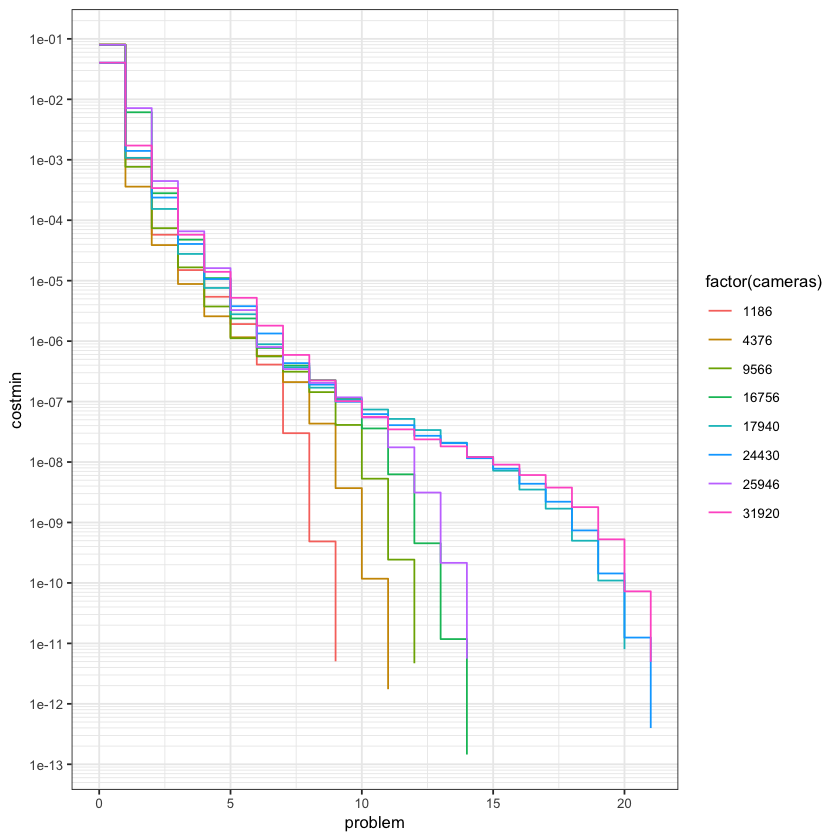

In [125]:
ggplot(ceres %>% dplyr::filter(grepl("block-drift", bal) & solver == "Point Block Jacobi" & robust == TRUE & eta == 0.01),
       aes(x=problem, y=costmin, color=factor(cameras))) +
  geom_step() +
  scale_y_log_eng()

In [102]:
#ceres %>% dplyr::filter(robust == TRUE) #%>% group_by(bal, solver) %>% mutate(reliters=iters/iters[robust == TRUE])
# iteration counts for robust vs not
d_agg %>% dplyr::filter(eta == 0.1) %>% group_by(solver,bal) %>% transmute(eta=eta, cameras=cameras, robust=robust, iters=iters) %>% spread(robust, iters)

solver,bal,eta,cameras,FALSE,TRUE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Multigrid,10-block,0.1,1979,2,NA
Multigrid,10-block-drift,0.1,1979,128,NA
Multigrid,10K-long-path,0.1,9996,NA,24
Multigrid,10K-long-path-drift,0.1,9996,NA,2
Multigrid,11K-path,0.1,11000,7161,10232
Multigrid,13K-3K-10,0.1,13142,3,NA
Multigrid,15-block,0.1,4468,2,NA
Multigrid,15-block-drift,0.1,4468,165,NA
Multigrid,15K-6K-inner-city,0.1,16175,1307,1307


In [103]:
d_bal = bind_rows(read_bals("ceres_benchmark_multigrid_robust01.csv", "Multigrid"),
                  read_bals("ceres_benchmark_pbjacobi_robust01.csv", "Point Block Jacobi"),
                  read_bals("ceres_benchmark_visibility_robust01.csv", "Visibility")
                 )
d_bal = d_bal %>% dplyr::filter(grepl("ladybug", bal))
d_bal = d_bal %>% group_by(bal, solver, eta, robust) %>%
  mutate(ctime = cumsum(setup_time)+cumsum(solve_time), ctime_solve=cumsum(solve_time), costmin=cummin(cost))
mincost = d_bal %>% dplyr::filter(is.element(solver, c("Multigrid", "Visibility", "Point Block Jacobi"))) %>%
  group_by(bal, solver, eta, robust) %>% summarize(mincost=min(cost))
maxmincost = mincost %>% group_by(bal, eta, robust) %>% summarize(maxmincost=max(mincost))
d_bal = inner_join(d_bal, maxmincost, by=c("bal", "eta", "robust"))
#TODO: this might keep later rows if cost goes back up
d_bal_sametol = d_bal %>% group_by(bal, solver, eta, robust) %>%
    group_modify(~ .x[.x$problem <= min(.x$problem[.x$cost <= .x$maxmincost]),])

Warning message:
“Removed 67 row(s) containing missing values (geom_path).”


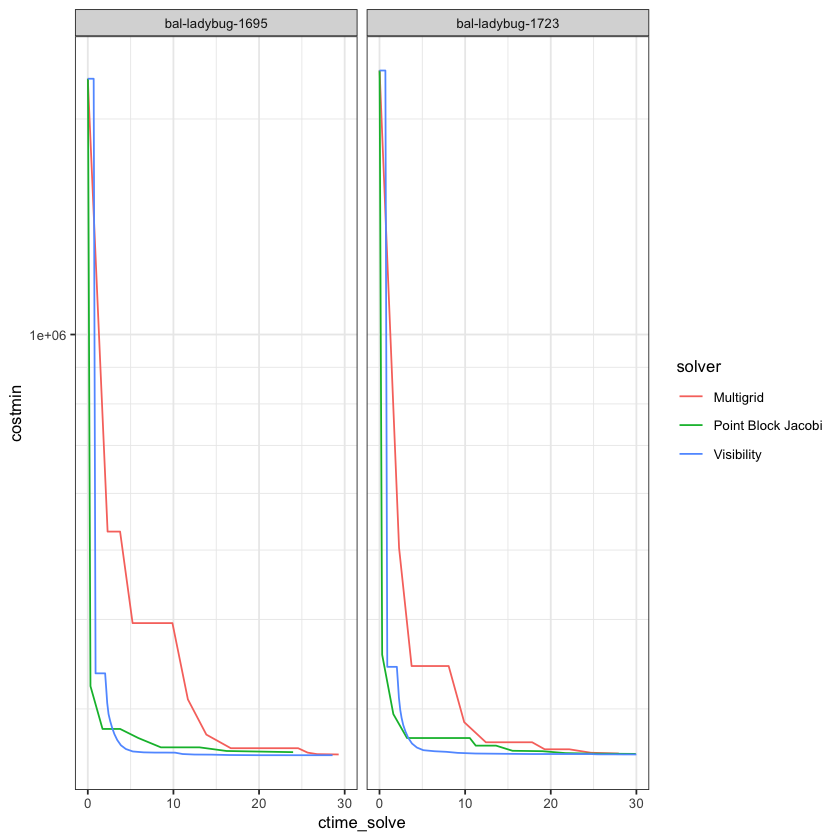

In [104]:
ggplot(d_bal_sametol, aes(x=ctime_solve, y=costmin, color=solver)) + geom_line() +
  facet_wrap(vars(bal)) + scale_y_log_eng() + xlim(0,30)

[1] "Writing to ../../thesis/condition_vs_nonlinear_iter.tex"


pdf 
  2

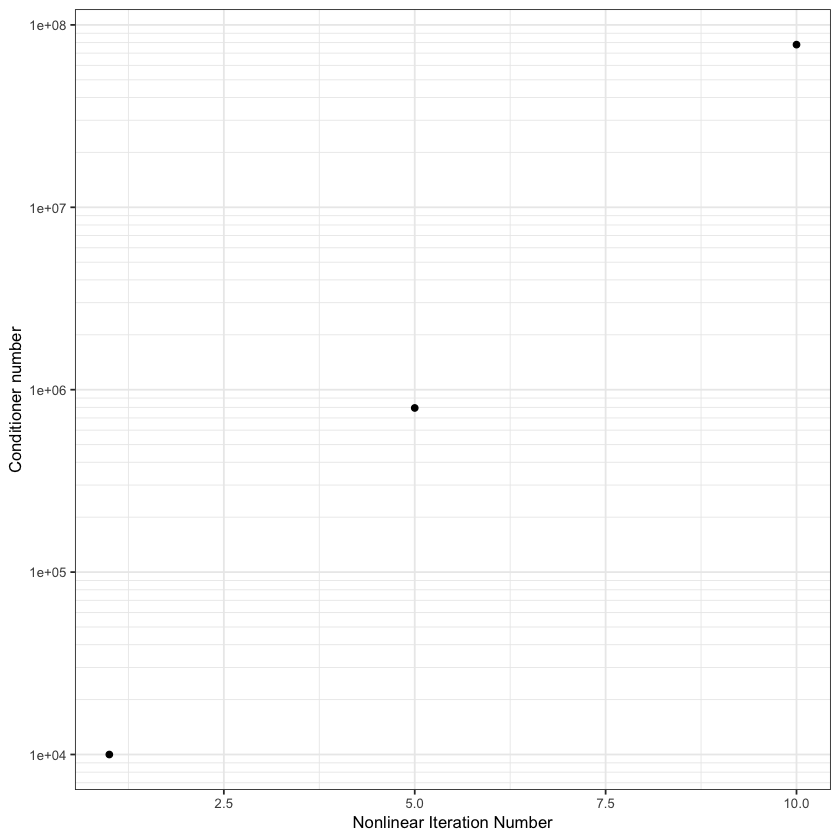

In [105]:
d = bind_rows(lapply(Sys.glob("../ba-problems/5_block_drift.problem/eig_*_smallest.h5"), function(x) {
    i = strtoi(str_extract(x,"(?<=_)\\d+(?=_)"))
    eg = h5read(x, "/eigenvalues")[1]
    egl = h5read(gsub("smallest", "largest", x), "/eigenvalues")[1]
    tibble(problem=i,cond=egl/eg)
    }))
ggplot(d, aes(x=problem,y=cond)) +
  geom_point() +
  scale_y_log_eng() +
  xlab("Nonlinear Iteration Number") +
  ylab("Conditioner number")
tikz_file("../../thesis/condition_vs_nonlinear_iter.tex")